In [69]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [125]:
df = pd.read_csv('pbp.csv')
df.head()

Quarter   Time  Down  ToGo Location  \
0        1  15:00   NaN   NaN   CIN 35   
1        1  15:00   1.0  10.0   LAR 25   
2        1  14:36   2.0   6.0   LAR 29   
3        1  13:52   1.0  10.0   LAR 36   
4        1  13:27   2.0  10.0   LAR 36   

                                              Detail  LAR  CIN   EPB   EPA  
0       Evan McPherson kicks off 65 yards touchback.    0    0  0.00  0.61  
1  Cam Akers left tackle for 4 yards (tackle by S...    0    0  0.61  0.60  
2  Matthew Stafford pass complete short middle to...    0    0  0.60  1.33  
3  Cam Akers left end for no gain (tackle by Chid...    0    0  1.33  0.79  
4  Matthew Stafford sacked by Trey Hendrickson fo...    0    0  0.79 -0.82

In [126]:
# Functions

In [127]:
def get_play_type(detail):
    detail = detail.lower()
    if 'pass' in detail:
        return 'pass'
    elif 'sacked' in detail:
        return 'pass'
    elif 'punt' in detail:
        return 'punt'
    elif 'kicks off' in detail:
        return 'kickoff'
    elif 'scrambles' in detail:
        return 'rush'
    elif 'penalty' in detail:
        return 'penalty'
    elif 'kneels' in detail:
        return 'kneel'
    else:
        return 'rush'

In [128]:
rams_offense = ['matthew stafford', 'matt gay', 'cam akers', 'darrell henderson', 'sony michel', 'johnny hekker', 'cooper kupp']
cin_offense = ['joe burrow', 'kevin huber', 'joe mixon', 'evan mcpherson', 'samaje perine', 'marr chase']

def get_team(detail):
    detail = detail.lower()
    match = 0
    for player in rams_offense:
        if player in detail:
            match += 1
            return 'LAR'
    for player in cin_offense:
        if player in detail:
            match += 1
            return 'CIN'
    
    return np.nan


In [129]:
def get_absolute_location(location, offense_team):
    team, yards = location.split(" ")
    if team == offense_team:
        return int(yards)
    else:
        return 100 - int(yards)

In [130]:
df['offense'] = df.apply(lambda x: get_team(x['Detail']), axis=1)
df['play_type'] = df.apply(lambda x: get_play_type(x['Detail']), axis=1)
df['epadded'] = df.EPA - df.EPB
df['abs_location'] = df.apply(lambda x: get_absolute_location(x['Location'], x['offense']), axis=1)
df.drop(df[df.play_type == 'penalty'].index, inplace=True)
df.head()

Quarter   Time  Down  ToGo Location  \
0        1  15:00   NaN   NaN   CIN 35   
1        1  15:00   1.0  10.0   LAR 25   
2        1  14:36   2.0   6.0   LAR 29   
3        1  13:52   1.0  10.0   LAR 36   
4        1  13:27   2.0  10.0   LAR 36   

                                              Detail  LAR  CIN   EPB   EPA  \
0       Evan McPherson kicks off 65 yards touchback.    0    0  0.00  0.61   
1  Cam Akers left tackle for 4 yards (tackle by S...    0    0  0.61  0.60   
2  Matthew Stafford pass complete short middle to...    0    0  0.60  1.33   
3  Cam Akers left end for no gain (tackle by Chid...    0    0  1.33  0.79   
4  Matthew Stafford sacked by Trey Hendrickson fo...    0    0  0.79 -0.82   

  offense play_type  epadded  abs_location  
0     CIN   kickoff     0.61            35  
1     LAR      rush    -0.01            25  
2     LAR      pass     0.73            29  
3     LAR      rush    -0.54            36  
4     LAR      pass    -1.61            36

<AxesSubplot:xlabel='offense', ylabel='epadded'>

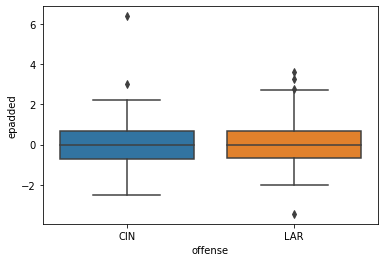

In [131]:
# df.loc[df.offense.isnull()]

sns.boxplot(y='epadded', data=df, x='offense')

In [132]:
cin_epa = df.loc[df.offense == 'CIN'].epadded.values
ram_epa = df.loc[df.offense == 'LAR'].epadded.values
print("CIN EPAs:", np.mean(cin_epa))
print("RAM EPAs:", np.mean(ram_epa))
round(stats.ttest_ind(cin_epa, ram_epa, equal_var = False)[1], 3)

CIN EPAs: 0.006447368421052611
RAM EPAs: 0.08107142857142859


0.711

In [133]:
rams_passing = df.loc[(df.offense == 'LAR') & (df.play_type == 'pass')].copy().reset_index()
rams_with_obj = rams_passing.iloc[:13].copy()
rams_without_obj = rams_passing.iloc[14:].copy()
rams_with_obj.drop(11, inplace=True) # delete wrong PAT

In [134]:
print("Durchschn. Passing-EPAs der Rams mit OBJ:", round(np.mean(rams_with_obj.epadded.values), 3))
print("Durchschn. Passing-EPAs Rams ohne OBJ:", round(np.mean(rams_without_obj.epadded.values), 3))
print("Welchs Test:", round(stats.ttest_ind(rams_with_obj.epadded.values, rams_without_obj.epadded.values, equal_var = False)[1], 3))

Durchschn. Passing-EPAs der Rams mit OBJ: 0.936
Durchschn. Passing-EPAs Rams ohne OBJ: -0.019
Welchs Test: 0.094


<AxesSubplot:xlabel='abs_location', ylabel='epadded'>

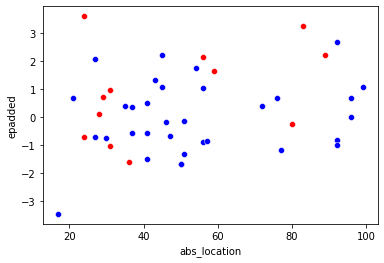

In [135]:
sns.scatterplot(x='abs_location', y='epadded', data=rams_with_obj, color='red')
sns.scatterplot(x='abs_location', y='epadded', data=rams_without_obj, color='blue')

<AxesSubplot:xlabel='abs_location', ylabel='epadded'>

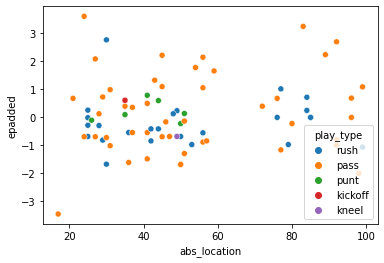

In [138]:
sns.scatterplot(x='abs_location', y='epadded', data=df.loc[df.offense == 'LAR'], hue='play_type')

In [140]:
rush_cin_1st = df.loc[(df.offense == 'CIN') & (df.Quarter <= 2) & (df.play_type == 'rush')].epadded.values
rush_cin_2st = df.loc[(df.offense == 'CIN') & (df.Quarter >= 2) & (df.play_type == 'rush')].epadded.values
print("Durchschn. Rush-EPAs der Bengals 1. HZ:", round(np.mean(rush_cin_1st), 3))
print("Durchschn. Rush-EPAs der Bengals 2. HZ:", round(np.mean(rush_cin_2st), 3))
print("Welchs Test:", round(stats.ttest_ind(rush_cin_1st, rush_cin_2st, equal_var = False)[1], 3))

Durchschn. Rush-EPAs der Bengals 1. HZ: 0.022
Durchschn. Rush-EPAs der Bengals 2. HZ: 0.122
Welchs Test: 0.753
